<center><h1>Short Time Fourier Transform</h1></center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft,get_window

# Parameters
fs = 1000  # Sampling frequency
duration = 1  # Duration of the signals (s)
N = fs * duration  # Number of samples
time = np.linspace(0, duration, N, endpoint=False)  # Time vector

### What do we need STFT when we already have DFT? ###
DFT provides a frequency representation of an entire signal, but it doesn't give any information about when specific frequencies occur. In contrast, STFT provides a time-frequency representation, allowing us to see how the frequency content of a signal changes over time. This is essential for analyzing signals that are non-stationary i.e. their frequency content changes over time.


In the snippet below we compute the fourier transform for two signals with frequency increasing and decreasing linearly with time respectively.

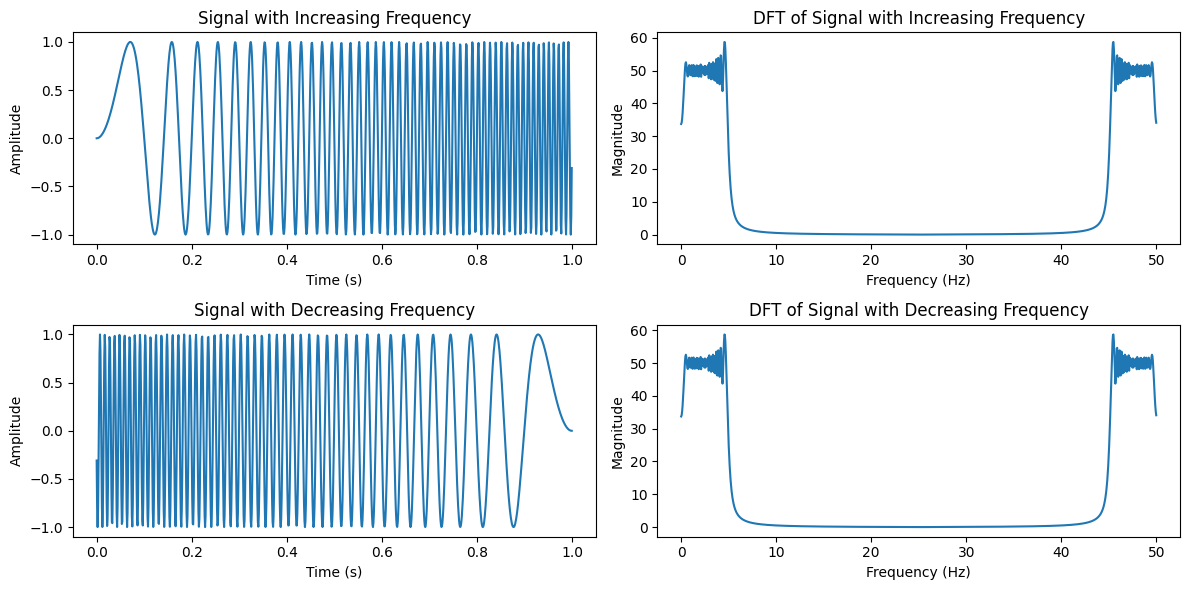

In [45]:
# Signal with increasing frequency
freq_inc = np.linspace(0, 50, N)
signal_inc = np.sin(2 * np.pi * freq_inc * time)

# Signal with decreasing frequency
signal_dec = signal_inc[::-1]

# Compute DFT
dft_inc = np.fft.fft(signal_inc)
dft_dec = np.fft.fft(signal_dec)

# Plot the signals
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2, 2, 1)
plt.plot(time, signal_inc)
plt.title('Signal with Increasing Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.plot(time, signal_dec)
plt.title('Signal with Decreasing Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



# Plot the DFT

plt.subplot(2, 2, 2)
plt.plot(freq_inc, np.abs(dft_inc))
plt.title('DFT of Signal with Increasing Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.subplot(2, 2, 4)
plt.plot(freq_inc, np.abs(dft_dec))
plt.title('DFT of Signal with Decreasing Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


We observe that the fourier transform for both the signals is very similar insipite of local frequency content being differnt. Thus we can infer that fourier transform by itself does not give any information about the local frequency content of a non-stationary signal.

### How is STFT performed?

Divide the signal into overlapping segments of equal length called frames, apply the Fourier Transform to each frame gives the frequency content of that frame. <br/>
Frames can be selected by multiplying the signal to a rectangular window function $w[n]$ which makes the signal zero outside the frame of interest.
$$ w[n] = \begin{cases} 
1 & \text{if } 0 \leq n < N \\
0 & \text{otherwise}
\end{cases} $$

Translated versions of the window select diffrent frames from the original singal. <br/>
Since, STFT gives frequency content for each frame, it is a function of both time (temporal position of frame) and frequency.
$$ STFT(m, k) = \sum_{n=-\infty}^{\infty} x[n] \cdot w[n - m] \cdot e^{-j \frac{2\pi}{N} n k} $$



where: <br/> 
$x[n]$ is the input signal <br/>
$w[n-m]$ is the window function translated to frame starting from time m <br/>
N is for N-point DFT, typically the frame size is also N (typically a power of 2) samples so that DFT can be computed using FFT.


In the snippet below we generate a signal with its frequency content varying with time.

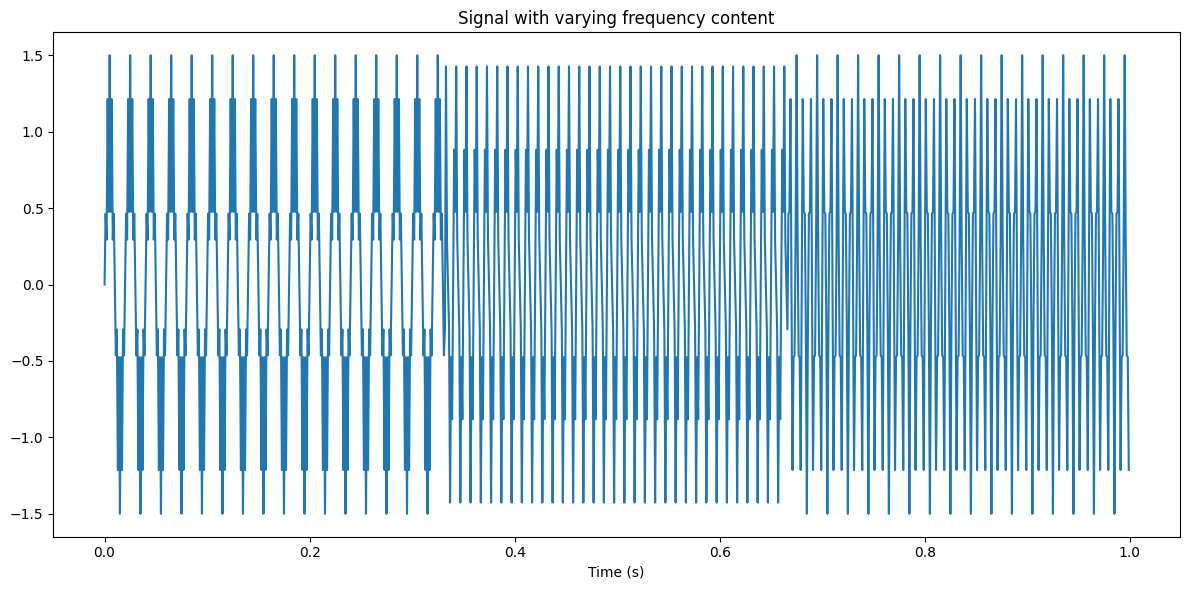

In [78]:
# Generate a sample signal

f1, f2 = 50, 450  
f3, f4 = 100, 400  
f5, f6 = 150, 350  

segment1 = np.sin(2 * np.pi * f1 * time[0:N//3])+0.5*np.sin(2 * np.pi * f2 * time[0:N//3])
segment2 = np.sin(2 * np.pi * f3 * time[N//3:2*N//3])+0.5*np.sin(2 * np.pi * f4 * time[N//3:2*N//3])
segment3 = np.sin(2 * np.pi * f5 * time[2*N//3:N])+0.5*np.sin(2 * np.pi * f6 * time[2*N//3:N])

signal = np.concatenate([segment1, segment2, segment3])

# plot the signal
plt.figure(figsize=(12, 6))

plt.plot(time, signal)
plt.title('Signal with varying frequency content')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

The frequency content of the 1 second long signal is varies with time as follows
- 50Hz (Amplitude=1) and 450Hz (Amplitude=0.5) for the first 333ms
- 100Hz (Amplitude=1) and 400Hz (Amplitude=0.5) for the next 333ms
- 150Hz (Amplitude=1) and 300Hz (Amplitude=0.5) for the last 334ms

Next, we compute STFT of the signal using the rectangular window described above.

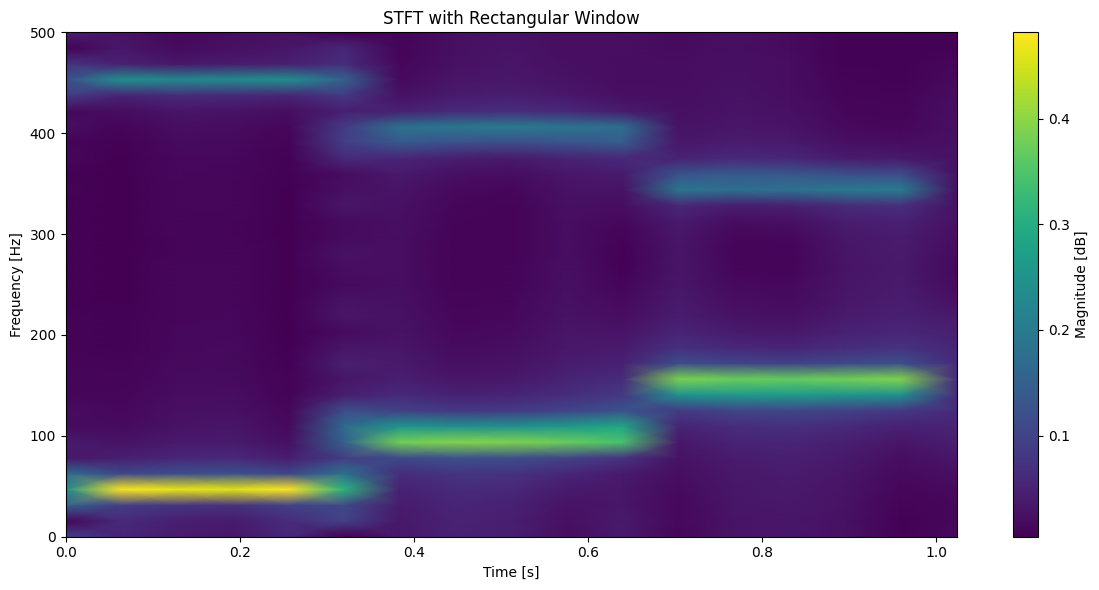

In [66]:
# STFT parameters
nfft = 64  # FFT size
window = 'boxcar'  # Rectangular window
noverlap = 0  # No overlap

# Compute STFT
f, t, Zxx = stft(signal, fs, window=window, nperseg=nfft, noverlap=noverlap)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT with Rectangular Window')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')
plt.tight_layout()
plt.show()

The Short Time Fourier Transform computed on the signal captures the change in the frequency content of the signal with time. <br/>
In the STFT:
- first 333ms have brighter band near 50Hz and paler band band near 450Hz
- next 333ms have brighter band near 100Hz and paler band band near 400Hz
- last 334ms have brighter band near 150Hz and paler band band near 300Hz

### Problem with rectangular window function?

Multiplying the signal with a rectangular window leads to **spectral leakage**:
1) discontinuities at the ends of a frame which appear as high frequency components in the fourier transform
2) convolution of the signal with sinc function (significant side lobes) in frequency domain which gives secondary peaks in the spectrum

We demonstarte the above two observations in the snippet below,

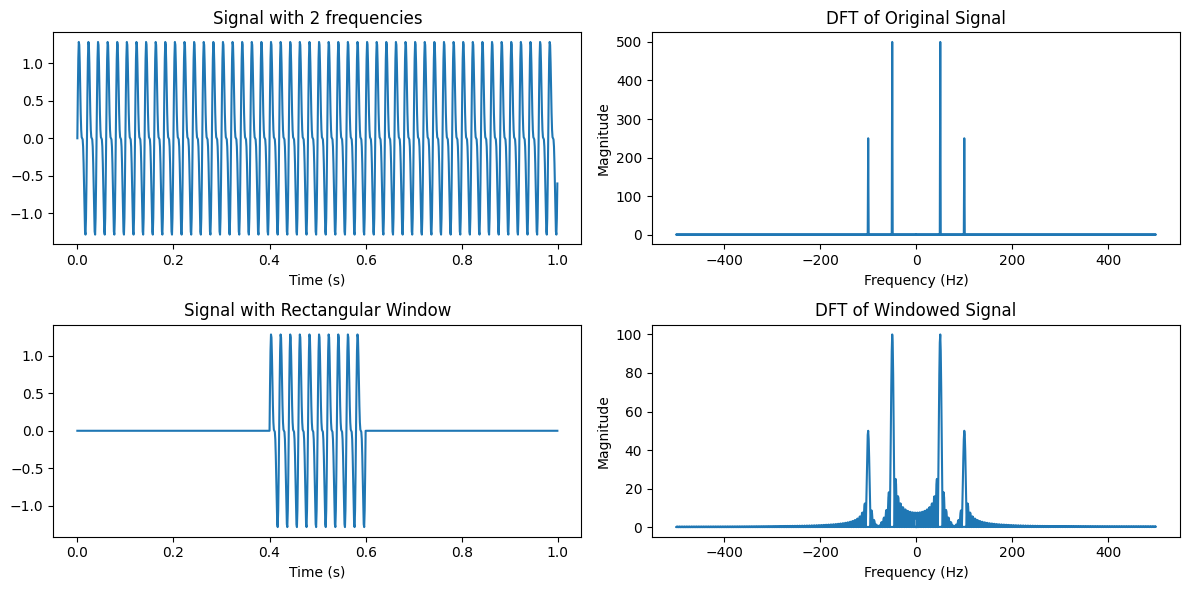

In [77]:
# signal with 2 frequencies
f1 = 50
f2 = 100
signal = np.sin(2 * np.pi * f1 * time) + 0.5*np.sin(2 * np.pi * f2 * time)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.subplots_adjust(hspace=0.5)

plt.plot(time, signal)
plt.title('Signal with 2 frequencies')
plt.xlabel('Time (s)')

# Rectangular window
window = np.zeros(N)
window[int(0.4 * N):int(0.6 * N)] = 1
windowed_signal = signal * window

plt.subplot(2, 2, 3)
plt.plot(time, windowed_signal)
plt.title('Signal with Rectangular Window')
plt.xlabel('Time (s)')

# Compute DFT
freqs = np.fft.fftfreq(N, 1/fs)
dft_signal = np.fft.fft(signal)
dft_windowed_signal = np.fft.fft(windowed_signal)

# Plot the DFT
plt.subplot(2, 2, 2)
plt.plot(freqs, np.abs(dft_signal))
plt.title('DFT of Original Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.subplot(2, 2, 4)
plt.plot(freqs, np.abs(dft_windowed_signal))
plt.title('DFT of Windowed Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

As observed, applying rectangular window to the signal, gives significant secondary peaks in the frequency domain, thus causing spectral leakage.

### Hanning window and overlapping frames

To avoid spectral leakge we use Hanning window which does to zero at the edges i.e. tapers the signal at the ends of the frame such that there are no discontuities. Also, it has significantly smaller side lobes which give smaller secondary peaks. Overall, using Hanning window reduces spectral leakge.
<br/>


$$ w[n] = 0.5 - 0.5 \cos\left(\frac{2\pi n}{N-1}\right) \quad \forall \quad n \quad \epsilon \quad \{0,1,...,N-1\}$$ 

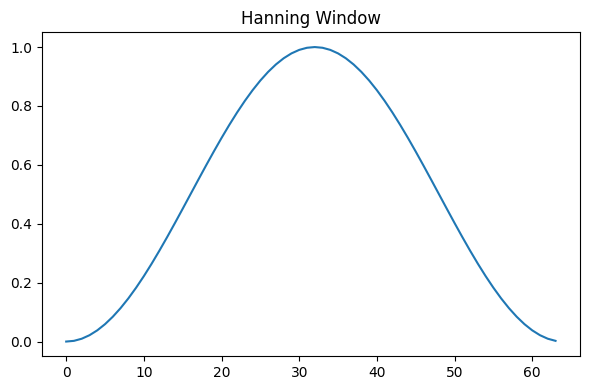

In [91]:
# plot hann window
window = get_window('hann', nfft)
plt.figure(figsize=(6, 4))
plt.plot(window)
plt.title('Hanning Window')

plt.tight_layout()
plt.show()


Next, we compare the effect of rectangular window and Hanning window on the spectrum of the signal.

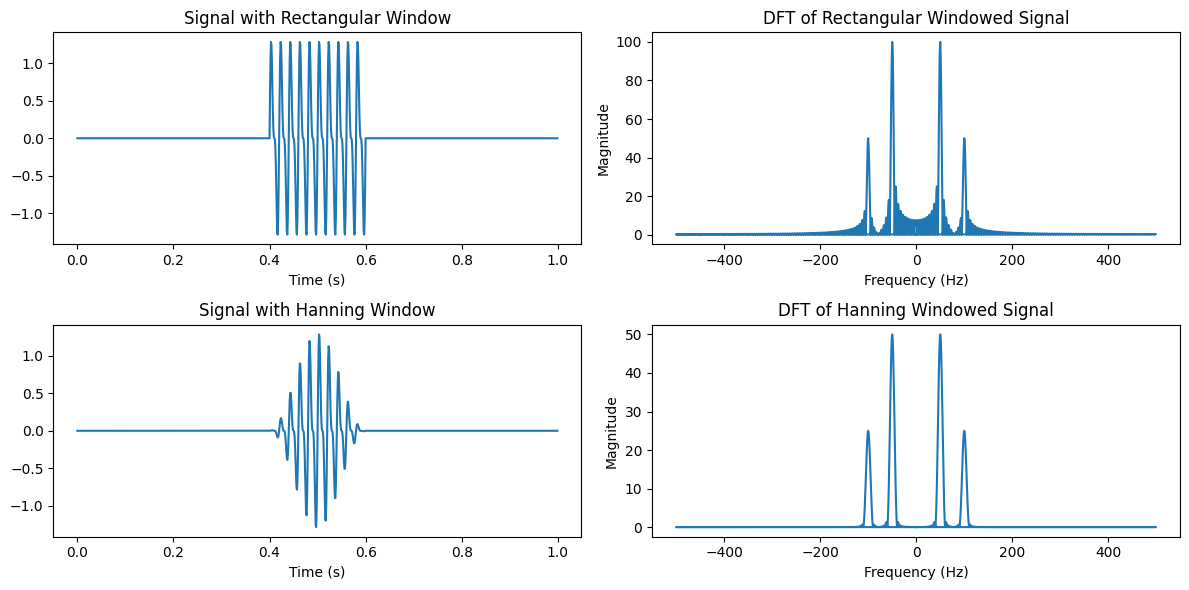

In [92]:
# signal with 2 frequencies
f1 = 50
f2 = 100
signal = np.sin(2 * np.pi * f1 * time) + 0.5*np.sin(2 * np.pi * f2 * time)

plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

start=0.4
end=0.6
# Rectangular window
rectangular_window = np.zeros(N)
rectangular_window[int(start * N):int(end * N)] = 1
rectangular_windowed_signal = signal * rectangular_window

plt.subplot(2, 2, 1)
plt.plot(time, rectangular_windowed_signal)
plt.title('Signal with Rectangular Window')
plt.xlabel('Time (s)')

# Hann window
hann_window = get_window('hann', int((end-start)*N)+1)
hann_window = np.pad(hann_window, (int(start*N), N-int(end*N)), mode='constant')
hann_windowed_signal = signal * hann_window

plt.subplot(2, 2, 3)
plt.plot(time, hann_windowed_signal)
plt.title('Signal with Hanning Window')
plt.xlabel('Time (s)')

# Compute DFT
freqs = np.fft.fftfreq(N, 1/fs)
dft_rectangular = np.fft.fft(rectangular_windowed_signal)
dft_hann = np.fft.fft(hann_windowed_signal)

# Plot the DFT
plt.subplot(2,2,2)
plt.plot(freqs, np.abs(dft_rectangular))
plt.title('DFT of Rectangular Windowed Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.subplot(2,2,4)
plt.plot(freqs, np.abs(dft_hann))
plt.title('DFT of Hanning Windowed Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


As observed, applying Hanning window on the signal leads to significantly less spectral leakage than that in the case of rectangular window. 

Since,  the signal goes to zero at the ends of the frame, we take overlappig frames so that information at the edges is not lost. <br/>
We define a hop size (H) less than N, by which the window is translated to obtain overlapping frames.  

Moving further, we compare STFT computed using rectangular and hann windows. 

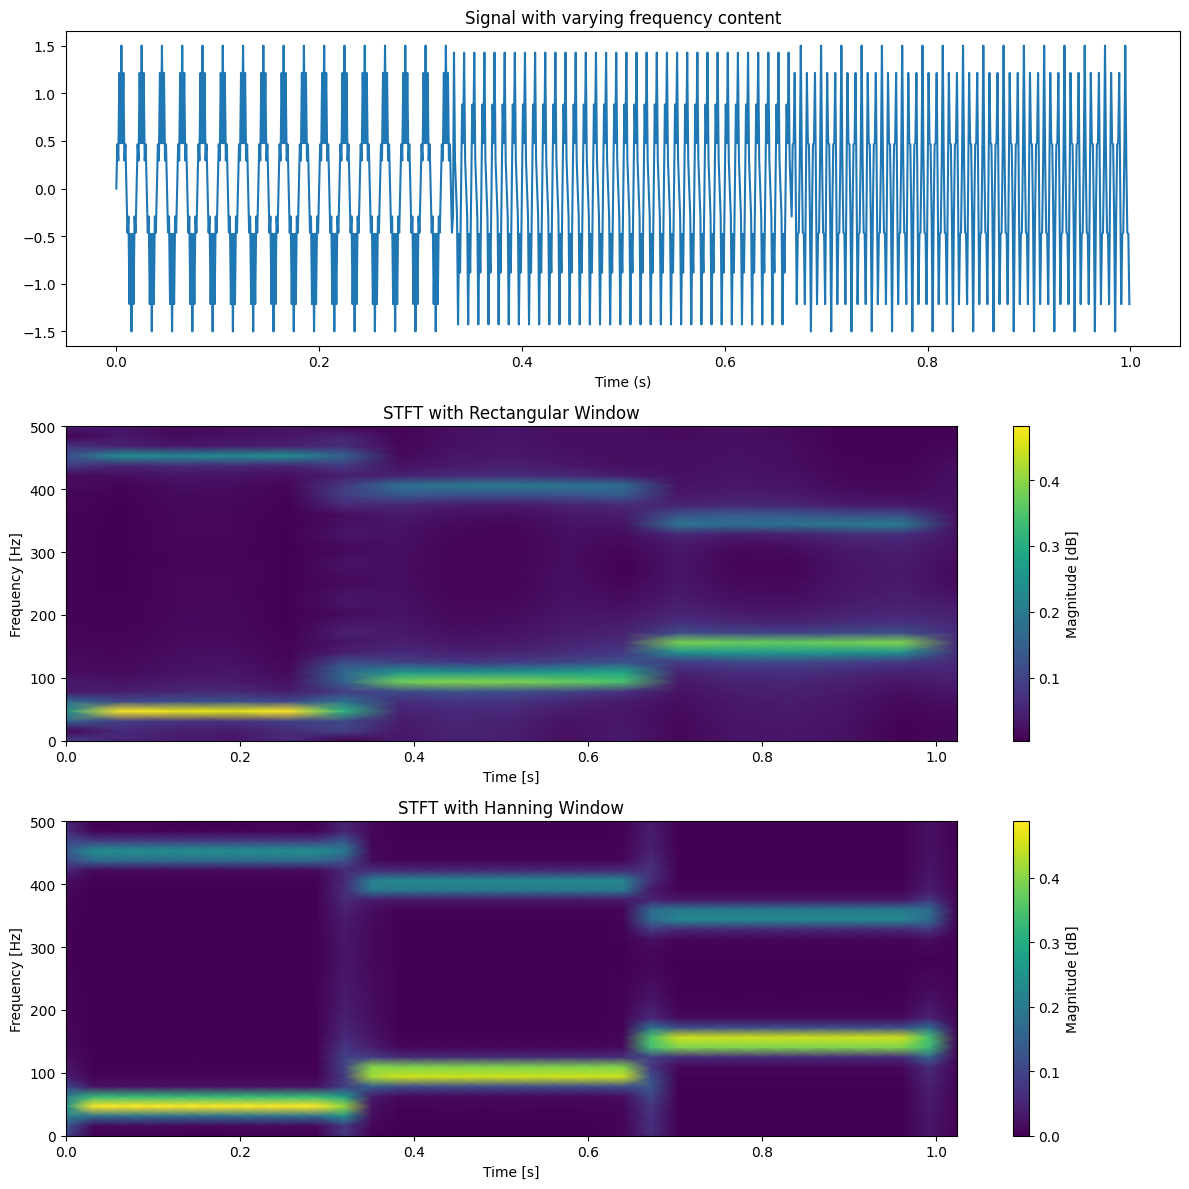

In [89]:
# Generate a sample signal
f1, f2 = 50, 450  
f3, f4 = 100, 400  
f5, f6 = 150, 350  

segment1 = np.sin(2 * np.pi * f1 * time[0:N//3])+0.5*np.sin(2 * np.pi * f2 * time[0:N//3])
segment2 = np.sin(2 * np.pi * f3 * time[N//3:2*N//3])+0.5*np.sin(2 * np.pi * f4 * time[N//3:2*N//3])
segment3 = np.sin(2 * np.pi * f5 * time[2*N//3:N])+0.5*np.sin(2 * np.pi * f6 * time[2*N//3:N])

signal = np.concatenate([segment1, segment2, segment3])

# plot the signal
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)
plt.plot(time, signal)
plt.title('Signal with varying frequency content')
plt.xlabel('Time (s)')

# STFT parameters
nfft = 64  # FFT size
rectangular_window = 'boxcar'  # Rectangular window
rectangular_noverlap = 0  # No overlap

hann_window = 'hann'  # Hann window
hann_noverlap = 32  # Overlap

# Compute STFT with Rectangular window
f, t, Zxx = stft(signal, fs, window=rectangular_window, nperseg=nfft, noverlap=noverlap)

# Plot the spectrogram
plt.subplot(3, 1, 2)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT with Rectangular Window')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')

# Compute STFT with Hann window
f, t, Zxx = stft(signal, fs, window=hann_window, nperseg=nfft, noverlap=hann_noverlap)

# Plot the spectrogram
plt.subplot(3, 1, 3)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT with Hanning Window')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')

plt.tight_layout()
plt.show()

We make the following observations:
- bands in STFT with Hanning window are brighter than the corresponding ones in STFT with rectangular window since applying Hanning window leads to significantly less spectral leakage than in the case of rectangular window.
- boundaries between any two segments with different frequency content are better pronounced (sharper) in the case of Hanning window, since the signal is forced to zero towards the edges of a frame, thus only the frequency content present in the middle of the frame is preserved in the spectrum. Whereas, in the case of rectangular window, frames at the boundary have frequency content from segments on either side of the boundary which leads to less pronounced (blunter) boundaries. This phenomenon of frequency content leaking to adjacent time frames is called **Time Smearing**.


### Resolution tradeoff

**Time resolution:** Shorter windows provide better time resolution, allowing us to capture fast changes in the signal and localize events in time more precisely. <br/>
**Frequency resolution:** Since width of the frequency bins in DFT is inversely proportional to the length of the analysis window (frame), longer windows provide better frequency resolution, allowing us to distinguish closely spaced frequency components.

Thus, we increase resolution in one domain by compromising on resolution in the other domain by varying the window size. 

The following code snippet demonstrates the above tradeoff on a signal having 5 segments with different frequency content.

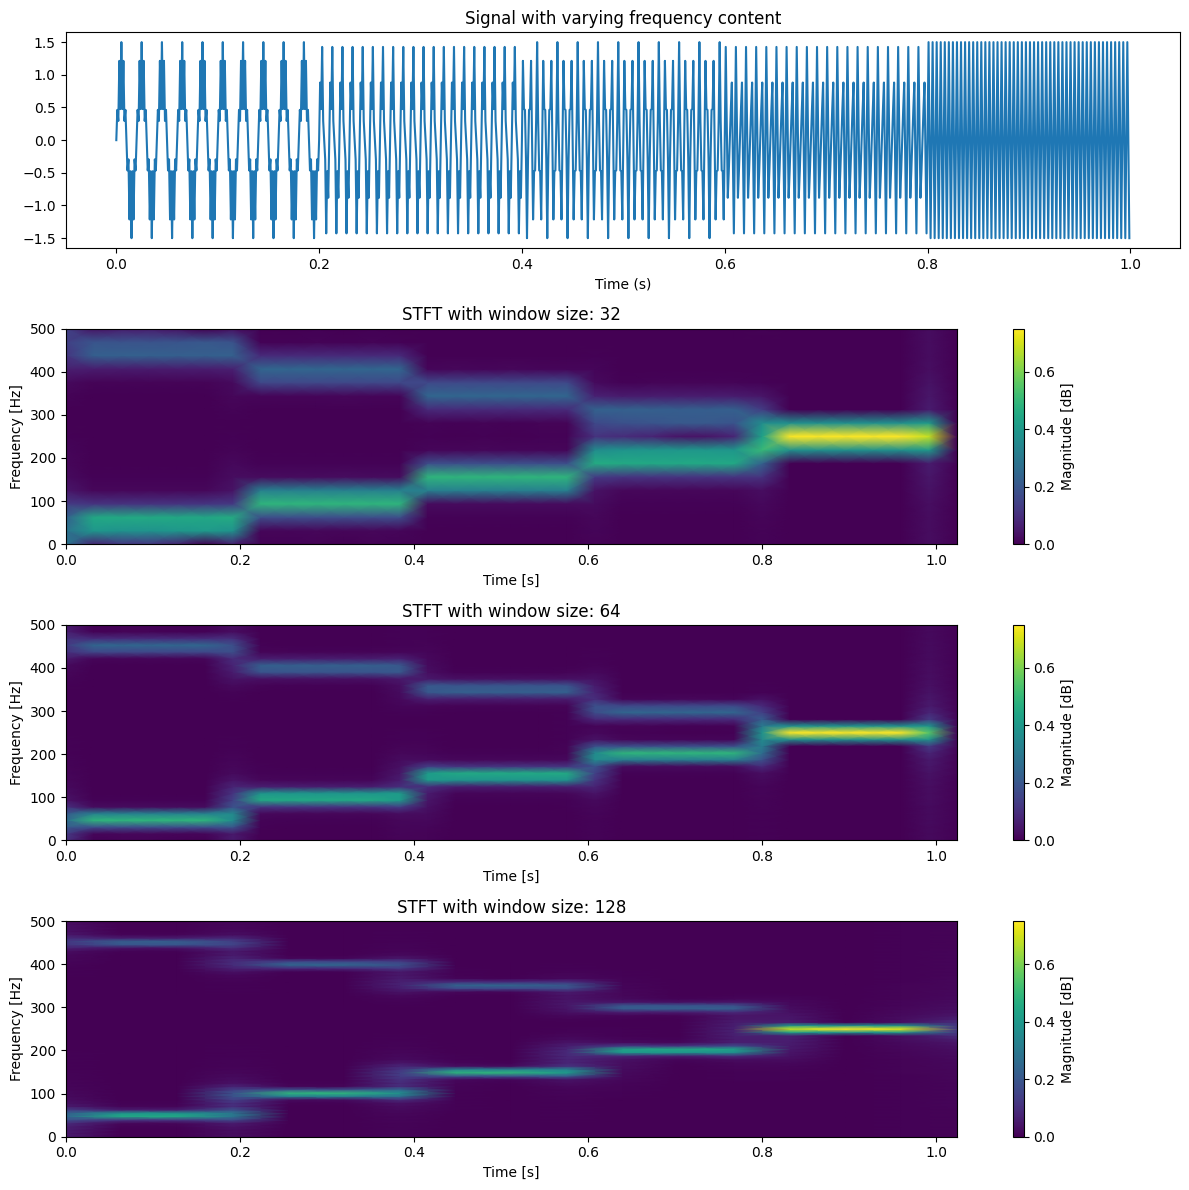

In [88]:
# Generate a sample signal
f1, f2 = 50, 450  
f3, f4 = 100, 400  
f5, f6 = 150, 350 
f7, f8=200,300
f9, f10=250,250 

segment1 = np.sin(2 * np.pi * f1 * time[0:N//5])+0.5*np.sin(2 * np.pi * f2 * time[0:N//5])
segment2 = np.sin(2 * np.pi * f3 * time[N//5:2*N//5])+0.5*np.sin(2 * np.pi * f4 * time[N//5:2*N//5])
segment3 = np.sin(2 * np.pi * f5 * time[2*N//5:3*N//5])+0.5*np.sin(2 * np.pi * f6 * time[2*N//5:3*N//5])
segment4 = np.sin(2 * np.pi * f7 * time[3*N//5:4*N//5])+0.5*np.sin(2 * np.pi * f8 * time[3*N//5:4*N//5])
segment5 = np.sin(2 * np.pi * f9 * time[4*N//5:N])+0.5*np.sin(2 * np.pi * f10 * time[4*N//5:N])

signal = np.concatenate([segment1, segment2, segment3,segment4,segment5])

# plot the signal
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)

plt.subplot(4, 1, 1)
plt.plot(time, signal)
plt.title('Signal with varying frequency content')
plt.xlabel('Time (s)')


window = 'hann'  # Hann window

nfft=32
hann_noverlap = nfft//2  # Overlap

# Compute STFT with Rectangular window
f, t, Zxx = stft(signal, fs, window=window, nperseg=nfft, noverlap=noverlap)

# Plot the spectrogram
plt.subplot(4, 1, 2)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title(f'STFT with window size: {nfft}')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')

nfft=64
hann_noverlap = nfft//2  # Overlap

# Compute STFT with Hann window
f, t, Zxx = stft(signal, fs, window=window, nperseg=nfft, noverlap=hann_noverlap)

# Plot the spectrogram
plt.subplot(4, 1, 3)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title(f'STFT with window size: {nfft}')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')


nfft=128
hann_noverlap = nfft//2  # Overlap

# Compute STFT with Hann window
f, t, Zxx = stft(signal, fs, window=window, nperseg=nfft, noverlap=hann_noverlap)

# Plot the spectrogram
plt.subplot(4, 1, 4)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title(f'STFT with window size: {nfft}')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Magnitude [dB]')


plt.tight_layout()
plt.show()

We observe that on increasing the window size:
- bands become thinner as a result of increase in frequency resolution, since the width of frequency bins decreases.
- boundary between segments with different frequency content becomes less pronounced as a result of decrease in time resolution, since frames at the boundary would have more signal content from segments on either side of the boundary.

**Summarizing:** In this tutorial, we covered various aspects of Short Time Fourier Transform, used to compute spectrogram of a non-stationary signal, such as  implemetation with rectangular window, drawbacks of rectangular window, Hanning window and overlap and finally, time-frequency resolution tradeoff.  

<center><h1>Thank You!</h1></center>